# Import libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datasist as ds
import user_agents as ua
import os as os
import datetime as dt
import math
import joblib
import copy
import mypackages.mymodules as md

In [30]:
#from geopy.geocoders import Nominatim
#from streetaddress import StreetAddressFormatter, StreetAddressParser
#from address import AddressParser, Address

from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  

In [31]:
#Classification
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score 
from sklearn.metrics import f1_score, fbeta_score, classification_report

#Logistic Models & Score structures
Logistic_models = {
    "LogisticRegression": LogisticRegression(),
    "KNNClassifier": KNeighborsClassifier(),
    "SVC": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifie": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier(use_label_encoder=False),
    "GaussianNaiveBayes": GaussianNB()
}

logscoresdf = pd.DataFrame(index=Logistic_models.keys(), 
                    columns=['TR_Accuracy', 'TS_Accuracy', 'Recall', 'Precision', 'F-1', 'F-Beta-2', 'F-Beta-0.5', 'TP', 'FP', 'FN', 'TN'])


In [32]:
%matplotlib inline
sns.set(rc={'figure.figsize': [10, 10]}, font_scale=1.2)

# Action Plan
### ID:
Unique Identifier for a row, There is a 50882 unique value for the 50882 records in the data set. So it will be excluded from the training data set
### City_Code:
Code for the City of the customers, this is categorical data, and there is no missing data. It follows specific pattern C##, where ## is digits from 1 till 36
### Region_Code:
Code for the Region of the customers, this is categorical data, and there is no missing data. It is represented as numbers; however, it should be a Nominal category, so hot encoding should be used to remove the ordinal from data. however, its correlation to Response is very low,
### Accomodation_Type:
Customer Owns or Rents the house, this Nominal categorical data, and there is no missing data.
### Reco_Insurance_Type: 
Joint or Individual type for the recommended insurance, this Nominal categorical data and there is no missing data.
### Is_Spouse:
If the customers are married to each other (in the case of joint insurance), this is Nominal categorical data, and there is no missing data. 
### Upper_Age, Lower_Age:
The maximum and minimum age of the customer is numeric data. It has no missing data. Their correlation with Response is very low.
### Health Indicator:
Encoded values for the health of the customer it is categorical data, and its value follows the pattern X#, where # is a number from 1 to 9. I will assume that is Nominal, not ordinal categorical data. There are 11691 (20%) records that have null values. There is two option to handle this missing data either to impute it with most frequent or fixed value that represents unknow health indicator.
### Holding_Policy_Type:
Type of holding policy, it is Categorical data represented as numbers from 1 to 4. I will assume it is Ordinal Categorical data. There are 20251 missing data that it will be imputed with constant value '0' represent customer who doesn't have a policy. 
### Holding_Policy_Duration:
Duration (in years) of holding policy (a policy that customer has already subscribed to with the company), it is a numeric value, and it has 20251 missing data which correspond for the customer who doesn't have holding policy. It will be imputed with constant value '0' to have the same meaning for a customer whose holding policy type is '0. There is another issue with the data; some records have a value of '14+'. This will be converted to number 15 and change the data type of the column to number. 
### Reco_Policy_Cat:
Encoded value for recommended health insurance, it is categorical data, and there is no missing data. It ranges from 1 to 22. It looks it is Ordinal Categorical data. 

### Reco_Policy_Premium:
Annual Premium (INR) for the recommended health insurance, this numeric values, there is no missing data, and the outliers are normal by the business. 

## Execution:
For this type of problem, we need to maximize the True Positive and minimize the False Positive to increase the chance of gaining new leads with fewer teleSales calls. So we will focus the measures on Precision and F-Beta 0.5 

# Load Data

In [33]:
# load data set 
df =pd.read_csv('HealthInsuranceLeads.csv')

# Explore Data

In [34]:
df.head()

ID City_Code  Region_Code Accomodation_Type Reco_Insurance_Type  Upper_Age  \
0   1        C3         3213            Rented          Individual         36   
1   2        C5         1117             Owned               Joint         75   
2   3        C5         3732             Owned          Individual         32   
3   4       C24         4378             Owned               Joint         52   
4   5        C8         2190            Rented          Individual         44   

   Lower_Age Is_Spouse Health Indicator Holding_Policy_Duration  \
0         36        No               X1                     14+   
1         22        No               X2                     NaN   
2         32        No              NaN                     1.0   
3         48        No               X1                     14+   
4         44        No               X2                     3.0   

   Holding_Policy_Type  Reco_Policy_Cat  Reco_Policy_Premium  Response  
0                  3.0               22              11628.0         0  
1                  NaN               22              30510.0         0  
2                  1.0               19               7450.0         1  
3                  3.0               19              17780.0         0  
4                  1.0               16              10404.0         0

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

In [36]:
df['Reco_Policy_Cat'].unique()

array([22, 19, 16, 17,  1, 18, 21, 13, 20,  9,  2,  4, 12,  6, 14, 11,  3,
        8,  7, 10, 15,  5], dtype=int64)

In [37]:
df.describe()

ID   Region_Code     Upper_Age     Lower_Age  \
count  50882.000000  50882.000000  50882.000000  50882.000000   
mean   25441.500000   1732.788707     44.856275     42.738866   
std    14688.512535   1424.081652     17.310271     17.319375   
min        1.000000      1.000000     18.000000     16.000000   
25%    12721.250000    523.000000     28.000000     27.000000   
50%    25441.500000   1391.000000     44.000000     40.000000   
75%    38161.750000   2667.000000     59.000000     57.000000   
max    50882.000000   6194.000000     75.000000     75.000000   

       Holding_Policy_Type  Reco_Policy_Cat  Reco_Policy_Premium      Response  
count         30631.000000     50882.000000         50882.000000  50882.000000  
mean              2.439228        15.115188         14183.950069      0.239947  
std               1.025923         6.340663          6590.074873      0.427055  
min               1.000000         1.000000          2280.000000      0.000000  
25%               1.000000        12.000000          9248.000000      0.000000  
50%               3.000000        17.000000         13178.000000      0.000000  
75%               3.000000        20.000000         18096.000000      0.000000  
max               4.000000        22.000000         43350.400000      1.000000

In [38]:
df.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
      dtype='object')

In [39]:
# Map columns to its category in columns dictionary 
org_columns_dic = copy.deepcopy(md.columns_dic)
org_columns_dic['Numeric']=['Upper_Age', 'Lower_Age', 'Holding_Policy_Duration','Reco_Policy_Premium']
org_columns_dic['Datetime']=[]
org_columns_dic['Timedelta']=[]
org_columns_dic['Categorical']=[ 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type',  'Is_Spouse', 'Health Indicator', 
        'Holding_Policy_Type',        'Reco_Policy_Cat']
org_columns_dic['String']=[]
org_columns_dic['y'] = ['Response']



In [40]:
org_columns_dic

{'Numeric': ['Upper_Age',
  'Lower_Age',
  'Holding_Policy_Duration',
  'Reco_Policy_Premium'],
 'Datetime': [],
 'Timedelta': [],
 'Categorical': ['City_Code',
  'Region_Code',
  'Accomodation_Type',
  'Reco_Insurance_Type',
  'Is_Spouse',
  'Health Indicator',
  'Holding_Policy_Type',
  'Reco_Policy_Cat'],
 'String': [],
 'y': ['Response']}

In [41]:
# Profile columns 
md.columns_profile(df=df, columns_dic = org_columns_dic)

ID(int64), No. unique values:50882
	[1 2 3 4 5]
__________________________________________________
City_Code(object), No. unique values:36
	['C3' 'C5' 'C24' 'C8' 'C9']
__________________________________________________
Region_Code(int64), No. unique values:5316
	[3213 1117 3732 4378 2190]
__________________________________________________
Accomodation_Type(object), No. unique values:2
	['Rented' 'Owned']
__________________________________________________
Reco_Insurance_Type(object), No. unique values:2
	['Individual' 'Joint']
__________________________________________________
Upper_Age(int64), No. unique values:58
	[36 75 32 52 44]
__________________________________________________
Lower_Age(int64), No. unique values:60
	[36 22 32 48 44]
__________________________________________________
Is_Spouse(object), No. unique values:2
	['No' 'Yes']
__________________________________________________
Health Indicator(object), No. unique values:10
	['X1' 'X2' nan 'X4' 'X3']
_______________________

In [42]:
sorted(df['City_Code'].unique())

['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C2',
 'C20',
 'C21',
 'C22',
 'C23',
 'C24',
 'C25',
 'C26',
 'C27',
 'C28',
 'C29',
 'C3',
 'C30',
 'C31',
 'C32',
 'C33',
 'C34',
 'C35',
 'C36',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9']

In [43]:
df['Holding_Policy_Duration'].unique()

array(['14+', nan, '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0',
       '11.0', '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

In [44]:
df[(df['Holding_Policy_Duration'].isna())&(df['Holding_Policy_Type'].isna())]['Holding_Policy_Duration'].isna().sum()

20251

In [45]:
sorted(df['Reco_Policy_Cat'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

# Data Cleaning

In [46]:
df[df['Holding_Policy_Duration'] == '14+']['Holding_Policy_Duration'].value_counts()

14+    4335
Name: Holding_Policy_Duration, dtype: int64

In [47]:
df.loc[df['Holding_Policy_Duration'] == '14+', 'Holding_Policy_Duration'] = '15'

In [48]:
df[df['Holding_Policy_Duration'] == '15']['Holding_Policy_Duration'].value_counts()

15    4335
Name: Holding_Policy_Duration, dtype: int64

# Correct Data Types

In [49]:
md.convert_datatype(df=df, columns_dic=org_columns_dic)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  float64
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(3), int64(6

# Virtualize Data

In [51]:
#from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report")

In [28]:
profile

In [52]:
org_columns_dic

{'Numeric': ['Upper_Age',
  'Lower_Age',
  'Holding_Policy_Duration',
  'Reco_Policy_Premium'],
 'Datetime': [],
 'Timedelta': [],
 'Categorical': ['City_Code',
  'Region_Code',
  'Accomodation_Type',
  'Reco_Insurance_Type',
  'Is_Spouse',
  'Health Indicator',
  'Holding_Policy_Type',
  'Reco_Policy_Cat'],
 'String': [],
 'y': ['Response']}

<AxesSubplot:>

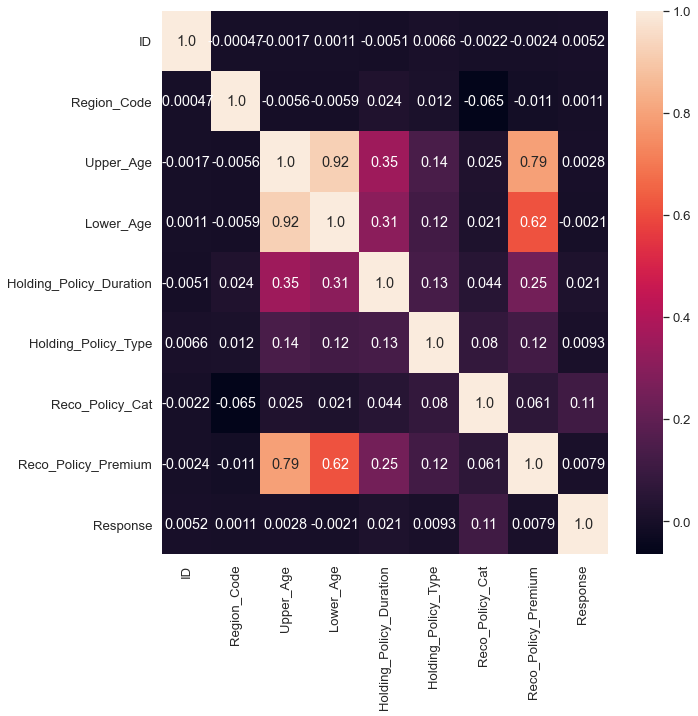

In [53]:
sns.heatmap(df.corr(),fmt=".2", annot=True)

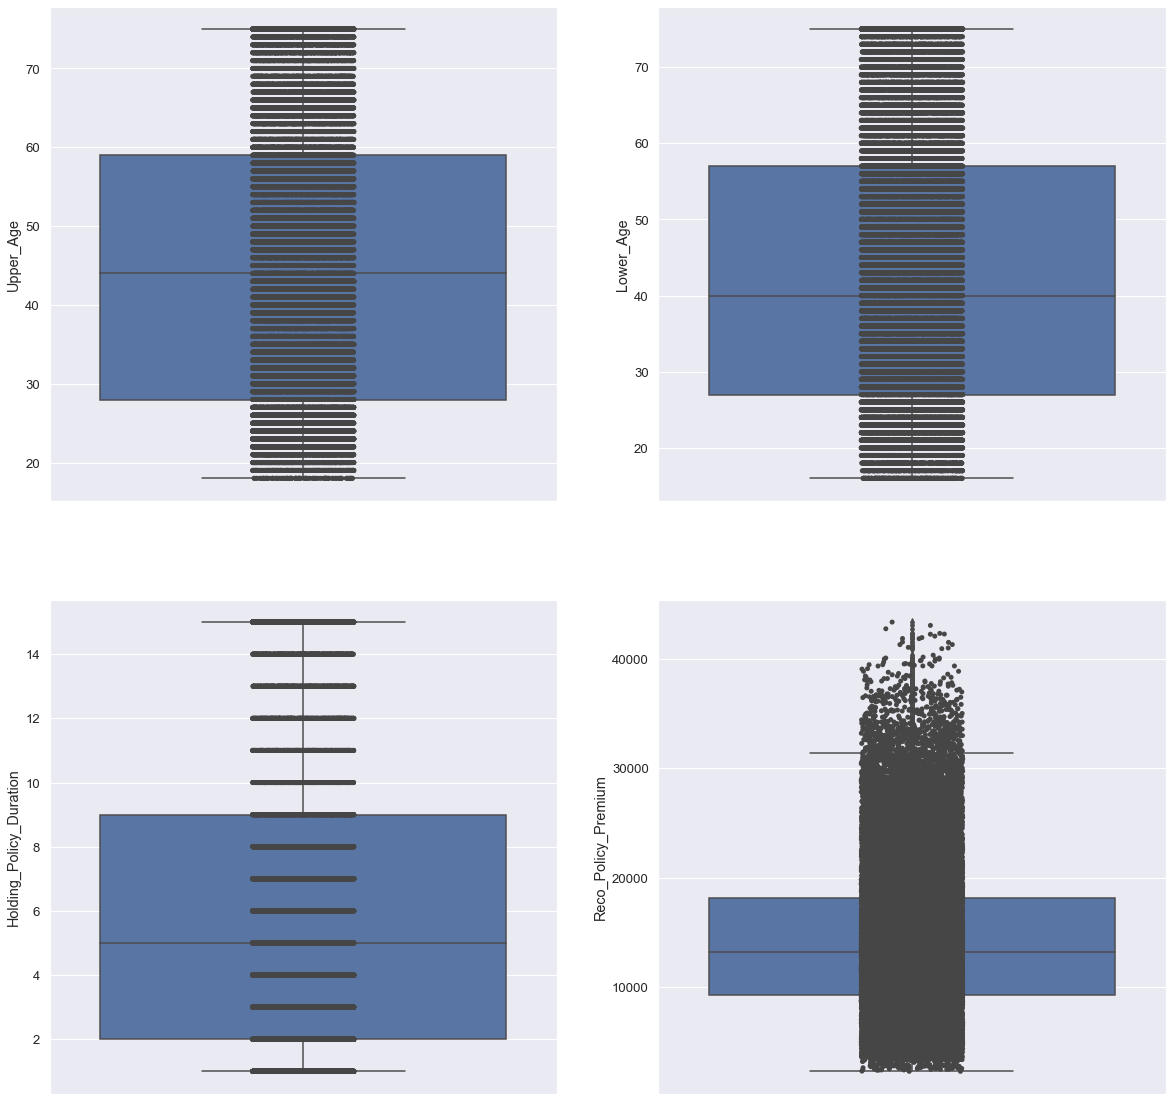

In [54]:
group = 'Numeric'
num_diagrams = len(org_columns_dic[group])
if num_diagrams > 1:
    fig, axes=plt.subplots (math.ceil(num_diagrams/2),2, figsize=(20,20), sharey=False)
    for i in range(num_diagrams):
        sns.boxplot(ax=axes[i//2][i%2], data=df, y=df[org_columns_dic[group][i]])
        sns.stripplot(ax=axes[i//2][i%2], data=df, y=df[org_columns_dic[group][i]], color="#474646")
else:
    sns.boxplot(data=df, y=df[org_columns_dic[group][0]])
    sns.stripplot(data=df, y=df[org_columns_dic[group][0]], color="#474646")


# Data Processing

Copy df (orginal) to dfdp (where will apply data processing), same apply for org_columns_dic

In [55]:
dfdp = df.copy()
dp_columns_dic = copy.deepcopy(org_columns_dic)

## a) Missing Data

In [56]:
dfdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  float64
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(3), int64(6

In [57]:
dfdp.isna().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

In [58]:
dfdp.loc[dfdp['Health Indicator'].isna() , 'Health Indicator'] = 'X0'
#imputer = SimpleImputer(strategy='most_frequent') #'mean' or 'median'
#dfdp['Health Indicator'] = imputer.fit_transform(dfdp[['Health Indicator']])


In [59]:
dfdp.loc[dfdp['Holding_Policy_Duration'].isna() , 'Holding_Policy_Duration'] = 0.0

In [60]:
dfdp.loc[dfdp['Holding_Policy_Type'].isna() , 'Holding_Policy_Type'] =  0.0

In [61]:
dfdp.isna().sum()

ID                         0
City_Code                  0
Region_Code                0
Accomodation_Type          0
Reco_Insurance_Type        0
Upper_Age                  0
Lower_Age                  0
Is_Spouse                  0
Health Indicator           0
Holding_Policy_Duration    0
Holding_Policy_Type        0
Reco_Policy_Cat            0
Reco_Policy_Premium        0
Response                   0
dtype: int64

## b) Categorical Data

In [62]:
dp_columns_dic

{'Numeric': ['Upper_Age',
  'Lower_Age',
  'Holding_Policy_Duration',
  'Reco_Policy_Premium'],
 'Datetime': [],
 'Timedelta': [],
 'Categorical': ['City_Code',
  'Region_Code',
  'Accomodation_Type',
  'Reco_Insurance_Type',
  'Is_Spouse',
  'Health Indicator',
  'Holding_Policy_Type',
  'Reco_Policy_Cat'],
 'String': [],
 'y': ['Response']}

In [63]:
dfdp = pd.get_dummies(data=dfdp,columns = ['City_Code'],drop_first=True)
#dfdp = pd.get_dummies(data=dfdp,columns = ['Region_Code'],drop_first=True)
dfdp = pd.get_dummies(data=dfdp,columns = ['Accomodation_Type'],drop_first=True)
dfdp = pd.get_dummies(data=dfdp,columns = ['Reco_Insurance_Type'],drop_first=True)
dfdp = pd.get_dummies(data=dfdp,columns = ['Is_Spouse'],drop_first=True)
#dfdp = pd.get_dummies(data=dfdp,columns = ['Health Indicator'],drop_first=True)
dfdp = pd.get_dummies(data=dfdp,columns = ['Holding_Policy_Type'],drop_first=True)
dfdp = pd.get_dummies(data=dfdp,columns = ['Reco_Policy_Cat'],drop_first=True)

In [64]:
dfdp.columns

Index(['ID', 'Region_Code', 'Upper_Age', 'Lower_Age', 'Health Indicator',
       'Holding_Policy_Duration', 'Reco_Policy_Premium', 'Response',
       'City_Code_C10', 'City_Code_C11', 'City_Code_C12', 'City_Code_C13',
       'City_Code_C14', 'City_Code_C15', 'City_Code_C16', 'City_Code_C17',
       'City_Code_C18', 'City_Code_C19', 'City_Code_C2', 'City_Code_C20',
       'City_Code_C21', 'City_Code_C22', 'City_Code_C23', 'City_Code_C24',
       'City_Code_C25', 'City_Code_C26', 'City_Code_C27', 'City_Code_C28',
       'City_Code_C29', 'City_Code_C3', 'City_Code_C30', 'City_Code_C31',
       'City_Code_C32', 'City_Code_C33', 'City_Code_C34', 'City_Code_C35',
       'City_Code_C36', 'City_Code_C4', 'City_Code_C5', 'City_Code_C6',
       'City_Code_C7', 'City_Code_C8', 'City_Code_C9',
       'Accomodation_Type_Rented', 'Reco_Insurance_Type_Joint',
       'Is_Spouse_Yes', 'Holding_Policy_Type_1.0', 'Holding_Policy_Type_2.0',
       'Holding_Policy_Type_3.0', 'Holding_Policy_Type_4.0',
    

In [65]:
dfdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 71 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         50882 non-null  int64  
 1   Region_Code                50882 non-null  int64  
 2   Upper_Age                  50882 non-null  int64  
 3   Lower_Age                  50882 non-null  int64  
 4   Health Indicator           50882 non-null  object 
 5   Holding_Policy_Duration    50882 non-null  float64
 6   Reco_Policy_Premium        50882 non-null  float64
 7   Response                   50882 non-null  int64  
 8   City_Code_C10              50882 non-null  uint8  
 9   City_Code_C11              50882 non-null  uint8  
 10  City_Code_C12              50882 non-null  uint8  
 11  City_Code_C13              50882 non-null  uint8  
 12  City_Code_C14              50882 non-null  uint8  
 13  City_Code_C15              50882 non-null  uin

# Train & Test Split

In [66]:
dfml = dfdp.copy()
ml_columns_dic = copy.deepcopy(dp_columns_dic)

In [67]:
ml_columns_dic

{'Numeric': ['Upper_Age',
  'Lower_Age',
  'Holding_Policy_Duration',
  'Reco_Policy_Premium'],
 'Datetime': [],
 'Timedelta': [],
 'Categorical': ['City_Code',
  'Region_Code',
  'Accomodation_Type',
  'Reco_Insurance_Type',
  'Is_Spouse',
  'Health Indicator',
  'Holding_Policy_Type',
  'Reco_Policy_Cat'],
 'String': [],
 'y': ['Response']}

In [68]:
dfml.columns

Index(['ID', 'Region_Code', 'Upper_Age', 'Lower_Age', 'Health Indicator',
       'Holding_Policy_Duration', 'Reco_Policy_Premium', 'Response',
       'City_Code_C10', 'City_Code_C11', 'City_Code_C12', 'City_Code_C13',
       'City_Code_C14', 'City_Code_C15', 'City_Code_C16', 'City_Code_C17',
       'City_Code_C18', 'City_Code_C19', 'City_Code_C2', 'City_Code_C20',
       'City_Code_C21', 'City_Code_C22', 'City_Code_C23', 'City_Code_C24',
       'City_Code_C25', 'City_Code_C26', 'City_Code_C27', 'City_Code_C28',
       'City_Code_C29', 'City_Code_C3', 'City_Code_C30', 'City_Code_C31',
       'City_Code_C32', 'City_Code_C33', 'City_Code_C34', 'City_Code_C35',
       'City_Code_C36', 'City_Code_C4', 'City_Code_C5', 'City_Code_C6',
       'City_Code_C7', 'City_Code_C8', 'City_Code_C9',
       'Accomodation_Type_Rented', 'Reco_Insurance_Type_Joint',
       'Is_Spouse_Yes', 'Holding_Policy_Type_1.0', 'Holding_Policy_Type_2.0',
       'Holding_Policy_Type_3.0', 'Holding_Policy_Type_4.0',
    

In [69]:
#Drop unwanted columns
dfml.drop(columns=['ID'], inplace=True)
#dfml.drop(columns=['City_Code'], inplace=True)
dfml.drop(columns=['Region_Code'], inplace=True)
#dfml.drop(columns=['Accomodation_Type'], inplace=True)
#dfml.drop(columns=['Reco_Insurance_Type'], inplace=True)
#dfml.drop(columns=['Upper_Age'], inplace=True)
#dfml.drop(columns=['Lower_Age'], inplace=True)
#dfml.drop(columns=['Is_Spouse'], inplace=True)
dfml.drop(columns=['Health Indicator'], inplace=True)
#dfml.drop(columns=['Holding_Policy_Duration'], inplace=True)
#dfml.drop(columns=['Holding_Policy_Type'], inplace=True)
#dfml.drop(columns=['Reco_Policy_Cat'], inplace=True)
#dfml.drop(columns=['Reco_Policy_Premium'], inplace=True)

In [70]:
#Create x & y sets
x=dfml.drop(columns=['Response'])
y=dfml['Response']


In [71]:
#Check columns
print(f'{md.style.BLUE}DataFrame Colmums: {md.style.BLACK}', end='')
print(dfml.columns)
print(f'{md.style.BLUE}x Colmums: {md.style.BLACK}', end='')
print(x.columns)
print(f'{md.style.BLUE}y Colmums: {md.style.BLACK}', end='')
print(ml_columns_dic['y'][0])

DataFrame Colmums: Index(['Upper_Age', 'Lower_Age', 'Holding_Policy_Duration',
       'Reco_Policy_Premium', 'Response', 'City_Code_C10', 'City_Code_C11',
       'City_Code_C12', 'City_Code_C13', 'City_Code_C14', 'City_Code_C15',
       'City_Code_C16', 'City_Code_C17', 'City_Code_C18', 'City_Code_C19',
       'City_Code_C2', 'City_Code_C20', 'City_Code_C21', 'City_Code_C22',
       'City_Code_C23', 'City_Code_C24', 'City_Code_C25', 'City_Code_C26',
       'City_Code_C27', 'City_Code_C28', 'City_Code_C29', 'City_Code_C3',
       'City_Code_C30', 'City_Code_C31', 'City_Code_C32', 'City_Code_C33',
       'City_Code_C34', 'City_Code_C35', 'City_Code_C36', 'City_Code_C4',
       'City_Code_C5', 'City_Code_C6', 'City_Code_C7', 'City_Code_C8',
       'City_Code_C9', 'Accomodation_Type_Rented', 'Reco_Insurance_Type_Joint',
       'Is_Spouse_Yes', 'Holding_Policy_Type_1.0', 'Holding_Policy_Type_2.0',
       'Holding_Policy_Type_3.0', 'Holding_Policy_Type_4.0',
       'Reco_Policy_Cat_2', 'Reco

In [72]:
#check shape
print(f'{md.style.BLUE}DataFrame Shape:  {md.style.BLACK}', end='')
print(dfml.shape)
print(f'{md.style.BLUE}x Shape: {md.style.BLACK}', end='')
print(x.shape)
print(f'{md.style.BLUE}y Shape: {md.style.BLACK}', end='')
print(y.shape)

DataFrame Shape:  (50882, 68)
x Shape: (50882, 67)
y Shape: (50882,)


In [73]:
#from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [74]:
#check shape
print(f'{md.style.BLUE}x_train shape: {md.style.BLACK}{x_train.shape}, ', end='')
print(f'{md.style.BLUE}y_train shape: {md.style.BLACK}{y_train.shape}')
print(f'{md.style.BLUE}x_test shape: {md.style.BLACK}{x_test.shape}, ', end='')
print(f'{md.style.BLUE}y_test shape: {md.style.BLACK}{y_test.shape}')

x_train shape: (40705, 67), y_train shape: (40705,)
x_test shape: (10177, 67), y_test shape: (10177,)


# Feature scaling

In [75]:
#from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(x_train)  
x_train = scaler.transform(x_train) 
x_test = scaler.transform(x_test)

# Imbalaced Clases 

In [76]:
#Check record count for each class
y_train.value_counts()

0    30933
1     9772
Name: Response, dtype: int64

In [77]:
#from imblearn.under_sampling import RandomUnderSampler  
sampler = RandomUnderSampler()  
x_train, y_train = sampler.fit_resample(x_train, y_train)  

#from imblearn.over_sampling import SMOTE  
#sampler = SMOTE()  
#x_train, y_train = sampler.fit_resample(x_train, y_train)  

y_train.value_counts()

1    9772
0    9772
Name: Response, dtype: int64

# Classification Model

In [78]:
y_test.value_counts().sort_index(ascending=False)

1    2437
0    7740
Name: Response, dtype: int64

Train and compare all models

In [79]:
#Compare all models
for name, model in Logistic_models.items():
    start = dt.datetime.now()
    print(f'Training Model: {name}, start: {start.hour:0>2}:{start.minute:0>2}:{start.second:0>2}', end="")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_test_pred)
    end = dt.datetime.now()
    diff = str(end-start).split('.')[0]
    print(f', end: {end.hour:0>2}:{end.minute:0>2}:{end.second:0>2}, duration: {diff}')
    logscoresdf.loc[name,'TR_Duration'] = diff
    logscoresdf.loc[name,'TR_Accuracy'] = accuracy_score(y_train,y_train_pred)
    logscoresdf.loc[name,'TS_Accuracy'] = accuracy_score(y_test, y_test_pred)
    logscoresdf.loc[name,'Recall'] = recall_score(y_test, y_test_pred)    
    logscoresdf.loc[name,'Precision'] = precision_score(y_test, y_test_pred, zero_division=0)
    logscoresdf.loc[name,'F-1'] = f1_score(y_test, y_test_pred)
    # change the sutable beta valuse
    logscoresdf.loc[name,'F-Beta-2'] = fbeta_score(y_test, y_test_pred, beta=2)  
    logscoresdf.loc[name,'F-Beta-0.5'] = fbeta_score(y_test, y_test_pred, beta=0.5)  
    logscoresdf.loc[name,'TN'] = cm[0][0] 
    logscoresdf.loc[name,'FN'] = cm[1][0] 
    logscoresdf.loc[name,'FP'] = cm[0][1] 
    logscoresdf.loc[name,'TP'] = cm[1][1] 
    

Training Model: LogisticRegression, start: 21:03:38, end: 21:03:38, duration: 0:00:00
Training Model: KNNClassifier, start: 21:03:38, end: 21:03:49, duration: 0:00:11
Training Model: SVC, start: 21:03:49, end: 21:05:38, duration: 0:01:48
Training Model: DecisionTreeClassifier, start: 21:05:38, end: 21:05:38, duration: 0:00:00
Training Model: RandomForestClassifie, start: 21:05:38, end: 21:05:42, duration: 0:00:03
Training Model: XGBClassifier, start: 21:05:42[21:05:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
, end: 21:05:43, duration: 0:00:01
Training Model: GaussianNaiveBayes, start: 21:05:43, end: 21:05:43, duration: 0:00:00


In [80]:
#Print models scores
print(f'{md.style.BLUE}Model score{md.style.BLACK}')
print(logscoresdf.sort_values(['Recall', 'Precision'], ascending=False))

Model score
                       TR_Accuracy TS_Accuracy    Recall Precision       F-1  \
GaussianNaiveBayes        0.551576     0.42036  0.788264  0.263007  0.394415   
SVC                       0.662556    0.587796  0.692245  0.328722  0.445766   
LogisticRegression        0.589951    0.568144  0.637259  0.306675  0.414078   
XGBClassifier             0.755117    0.589368  0.636438   0.32019   0.42604   
KNNClassifier             0.731631    0.586126  0.616742  0.314369  0.416459   
RandomForestClassifie     0.999795    0.598212  0.599918  0.319493   0.41694   
DecisionTreeClassifier    0.999795     0.56441   0.56668  0.290248  0.383878   

                        F-Beta-2 F-Beta-0.5    TP    FP    FN    TN  \
GaussianNaiveBayes      0.563277   0.303447  1921  5383   516  2357   
SVC                     0.566868   0.367298  1687  3445   750  4295   
LogisticRegression      0.524237   0.342176  1553  3511   884  4229   
XGBClassifier           0.531456   0.355522  1551  3293   886  

In [81]:
#Select the most accurate model 
name = 'SVC'
selected_model = Logistic_models[name]
selected_model.fit(x_train, y_train)
y_sm_train_pred = selected_model.predict(x_train)
y_sm_test_pred = selected_model.predict(x_test)
cm = confusion_matrix(y_test, y_sm_test_pred)
print(f'{md.style.BLUE}Selected Model: {md.style.GREEN}{name}{md.style.BLACK}')
print(f'Training Accuracy: {accuracy_score(y_train, y_sm_train_pred)}')
print(f'Testing Accuracy: {accuracy_score(y_test, y_sm_test_pred)}')
print(f'Testing Recall: {recall_score(y_test, y_sm_test_pred)}')    
print(f'Testing Precision : {precision_score(y_test, y_sm_test_pred)}')
print(f'Testing F-1: {f1_score(y_test, y_sm_test_pred)}')
# change the sutable beta valuse
print(f'Testing F-Beta 2: {fbeta_score(y_test, y_sm_test_pred, beta=2)}')
print(f'Testing F-Beta 0.5: {fbeta_score(y_test, y_sm_test_pred, beta=0.5)}')
print(f'Testing Confusion Matrix: \n{cm}')

Selected Model: SVC
Training Accuracy: 0.662556283258289
Testing Accuracy: 0.5877960106121647
Testing Recall: 0.6922445629872794
Testing Precision : 0.32872174590802805
Testing F-1: 0.4457656229356586
Testing F-Beta 2: 0.5668682795698925
Testing F-Beta 0.5: 0.36729806226866973
Testing Confusion Matrix: 
[[4295 3445]
 [ 750 1687]]


In [82]:
pd.Series(y_sm_test_pred).value_counts().sort_index(ascending=False)

1    5132
0    5045
dtype: int64

In [150]:
y_test

22810    0
43139    0
44298    1
10943    0
30967    1
        ..
9478     0
48101    1
48813    1
47103    0
19657    0
Name: Response, Length: 10177, dtype: int64

In [151]:
y_sm_test_pred

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

# Conclusion
After multiple runs with different features, we found that Region_Code and Health Indicators have a negative impact on the model as they reduce the Precision and F-Beta 0.5, so both are excluded from the final run.

# Save Model

In [152]:
#import joblib
joblib.dump(selected_model, 'HealthLeaddmodel.h5')

['HealthLeaddmodel.h5']

In [153]:
joblib.dump(scaler, 'HealthLeadscaler.h5')

['HealthLeadscaler.h5']

In [154]:
joblib.dump(x.columns, 'HealthLeadcolumns.h5')

['HealthLeadcolumns.h5']

In [155]:
x.columns

Index(['Upper_Age', 'Lower_Age', 'Holding_Policy_Duration',
       'Reco_Policy_Premium', 'City_Code_C10', 'City_Code_C11',
       'City_Code_C12', 'City_Code_C13', 'City_Code_C14', 'City_Code_C15',
       'City_Code_C16', 'City_Code_C17', 'City_Code_C18', 'City_Code_C19',
       'City_Code_C2', 'City_Code_C20', 'City_Code_C21', 'City_Code_C22',
       'City_Code_C23', 'City_Code_C24', 'City_Code_C25', 'City_Code_C26',
       'City_Code_C27', 'City_Code_C28', 'City_Code_C29', 'City_Code_C3',
       'City_Code_C30', 'City_Code_C31', 'City_Code_C32', 'City_Code_C33',
       'City_Code_C34', 'City_Code_C35', 'City_Code_C36', 'City_Code_C4',
       'City_Code_C5', 'City_Code_C6', 'City_Code_C7', 'City_Code_C8',
       'City_Code_C9', 'Accomodation_Type_Rented', 'Reco_Insurance_Type_Joint',
       'Is_Spouse_Yes', 'Holding_Policy_Type_1.0', 'Holding_Policy_Type_2.0',
       'Holding_Policy_Type_3.0', 'Holding_Policy_Type_4.0',
       'Reco_Policy_Cat_2', 'Reco_Policy_Cat_3', 'Reco_Policy_Ca

# Training Completed